In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

class NeuralNetwork:

    @staticmethod
    def sigma(x):
        return 1 / (np.exp(-x) + 1)

    @staticmethod
    def sigma_deriv(x):
        sig = NeuralNetwork.sigma(x)
        deriv = sig * (1 - sig)
        return deriv

    @staticmethod
    def softmax(x):
        # softmax function ---------
        t = np.exp(x - np.max(x))
        return t / np.sum(t, axis=1, keepdims=True)

    @staticmethod
    def get_activation_function(name):
        if name == 'sigma':
            return NeuralNetwork.sigma
        elif name == 'linear':
            return lambda x: x
        elif name == 'softmax':
            return NeuralNetwork.softmax
        elif name == 'tanh':
            return np.tanh
        elif name == 'relu':
            return lambda x: np.maximum(0, x)

    @staticmethod
    def get_activation_derivative(name):
        if name == 'sigma':
            return NeuralNetwork.sigma_deriv
        elif name == 'linear':
            return lambda x: np.ones_like(x)
        elif name == 'softmax':
            # jacobian of softmax - unused -------
            def softmax_deriv(x):
                value = NeuralNetwork.softmax(x)
                SM = value.reshape((-1, 1))
                jac = np.diagflat(value) - np.dot(SM, SM.T)
                return jac

            return softmax_deriv
        elif name == 'tanh':
            return lambda x: 1 - np.tanh(x)**2
        elif name == 'relu':
            return lambda x: x > 0


    @staticmethod
    def get_loss_function(name):
        if name == 'mse':
            return lambda x_pred, x: np.linalg.norm(x_pred - x)
        elif name == 'mae':
            return lambda x_pred, x: np.sum(np.abs(x_pred - x))
        elif name == 'crossentropy':
            return lambda x_pred, x: -np.sum(x*np.log(x_pred))

    @staticmethod
    def get_loss_derivative(name):
        # currently unused
        if name == 'mse':
            return lambda x_pred, x: (x_pred - x)
        if name == 'mae':
            return lambda x_pred, x: np.sign(x_pred - x)
        elif name == 'crossentropy':
            return lambda x_pred, x: x*(-1/x_pred)

    class Layer:
        def __init__(self, input_width, layer_width, activation_function):
            # self.weights = np.random.uniform(0, 1, (input_width + 1, layer_width))
            self.weights = np.random.normal(0, 1, (input_width + 1, layer_width))
            self.activation_function = activation_function

        def predict(self, x):
            activation_function = NeuralNetwork.get_activation_function(self.activation_function)
            return activation_function(np.dot(x, self.weights))

        def feedforward_step(self, x):
            activation_function = NeuralNetwork.get_activation_function(self.activation_function)
            activation = np.dot(x, self.weights)
            response = activation_function(activation)
            return response, activation

    def __init__(self, input_width, output_width, activation_function='sigma', loss_function='mse', bias_exists=True, seed=None, verbose=True):
        ###
        # create a new nn object. activation_function specifies activation used on hidden layers
        # loss_function affects loss printed to console
        ###
        self.input_width = input_width
        self.output_width = output_width
        self.layers = []
        self.activation_function = activation_function
        self.loss_function = NeuralNetwork.get_loss_function(loss_function)
        self.loss_derivative = NeuralNetwork.get_loss_derivative(loss_function)
        self.bias_exists = bias_exists
        self.seed = seed
        self.verbose = verbose
        if self.seed is not None:
            np.random.seed(self.seed)

    def add_layer(self, layer_width):
        ###
        # add a hidden layer with specified number of neurons
        ###
        if len(self.layers) == 0:
            self.layers.append(NeuralNetwork.Layer(self.input_width, layer_width, self.activation_function))
        else:
            self.layers.append(
                NeuralNetwork.Layer(self.layers[-1].weights.shape[1], layer_width, self.activation_function))


    def predict(self, x):
        ###
        # predict responses on new data
        ###
        values = np.copy(x)
        for layer in self.layers:
            values = np.hstack((values, np.ones((values.shape[0], 1)) if self.bias_exists else np.zeros((values.shape[0], 1))))
            values = layer.predict(values)
        return values

    def create_output_layer(self, activation_function='linear'):
        ###
        # create output layer with specified activation function. Use after adding all hidden layers and before training
        ###
        if len(self.layers) == 0:
            self.layers.append(NeuralNetwork.Layer(self.input_width, self.output_width, activation_function))
        else:
            self.layers.append(
                NeuralNetwork.Layer(self.layers[-1].weights.shape[1], self.output_width, activation_function))

    def feedforward(self, x):
        response = np.copy(x)
        response = response.reshape(1, -1)
        response = np.hstack((response, np.ones((response.shape[0], 1))))
        response_s = [response]
        activation_s = []
        for i in range(len(self.layers) - 1):
            response, activation = self.layers[i].feedforward_step(response_s[i])
            activation_s.append(activation)
            response = response.reshape(1, -1)
            response = np.hstack((response, np.ones((response.shape[0], 1))))
            response_s.append(response)
        response, activation = self.layers[-1].feedforward_step(response_s[-1])
        activation_s.append(activation)
        response = response.reshape(1, -1)
        response_s.append(response)
        return (response_s, activation_s)

    def backpropagation(self, x, y, r_s, a_s):
        e_s = [None] * len(self.layers)

        ###
        # derivative of loss function in respect to final layer weights
        # assuming loss is crossentropy and output layer is softmax
        # formula is the same as in the case of linear outputs and mse
        ###
        e_s[-1] = a_s[-1] - y

        for i in reversed(range(1, len(e_s))):
            unbiased_weights = self.layers[i].weights[0:(self.layers[i].weights.shape[0] - 1), :]
            e_s[i-1] = NeuralNetwork.get_activation_derivative(self.layers[i-1].activation_function)(a_s[i-1])*(e_s[i].dot(unbiased_weights.T))
        gradient = [r_s[j].T.dot(e_s[j]) for j in range(0, len(self.layers))]
        return gradient

    def train(self, x, y, batch_size=10, epochs=100, lr=0.01, method='basic', method_param=0.0):
        ###
        # train network. method can be 'basic', 'momentum' or 'rmsprop'.
        # method_param specifies lambda in momentum or beta in rmsprop
        ###
        errors = []
        eps = 1e-8
        momentum = [np.zeros(layer.weights.shape) for layer in self.layers]
        for e in range(epochs):
            permutation = np.random.permutation(y.shape[0])
            x = x[permutation, :]
            y = y[permutation, :]
            i = 0
            while i < y.shape[0]:
                deltas = [np.zeros(layer.weights.shape) for layer in self.layers]
                x_batch = x[i:i + batch_size, :]
                y_batch = y[i:i + batch_size, :]
                i = i + batch_size
                for j in range(0, y_batch.shape[0]):
                    r_s, a_s = self.feedforward(x_batch[j, :])
                    gradient = self.backpropagation(x_batch[j, :], y_batch[j, :], r_s, a_s)
                    for k in range(0, len(deltas)):
                        deltas[k] = deltas[k] - gradient[k]

                if method == 'momentum':
                    momentum = [delta + method_param * mom for mom, delta in zip(momentum, deltas)]
                elif method == 'rmsprop':
                    momentum = [method_param * mom + (1 - method_param)*np.square(delta) for mom, delta in zip(momentum, deltas)]

                for j in range(0, len(deltas)):
                    if method == 'momentum':
                        self.layers[j].weights = self.layers[j].weights + lr*momentum[j]
                    elif method == 'rmsprop':
                        self.layers[j].weights = self.layers[j].weights + lr * (deltas[j] / (np.sqrt(momentum[j]) + eps))
                    else:
                        self.layers[j].weights = self.layers[j].weights + lr*deltas[j]

                error = self.loss_function(self.predict(x_batch), y_batch)
                if self.verbose:
                    print("loss on batch = {}".format(error))
                errors.append(error)
        return errors

In [2]:
data = {"regression": {},
        "classification": {}}

def load_data(dictionary, target, name):
    file = pd.read_csv("projekt1/" + target + "/data." + name + ".train.10000.csv")
    X_train = np.array(file.iloc[:,:file.shape[1]-1])
    y_train = np.array(file.iloc[:,file.shape[1]-1:])
    file = pd.read_csv("projekt1/" + target + "/data." + name + ".test.10000.csv")
    X_test = np.array(file.iloc[:,:file.shape[1]-1])
    y_test = np.array(file.iloc[:,file.shape[1]-1:])
    if target == "regression":       
        X_test = (X_test - np.mean(X_train)) / np.std(X_train)
        y_test = (y_test - np.mean(y_train)) / np.std(y_train)
        X_train = (X_train - np.mean(X_train)) / np.std(X_train)
        y_train = (y_train - np.mean(y_train)) / np.std(y_train)
    elif target == "classification":
        X_test = (X_test - np.mean(X_train)) / np.std(X_train)
        X_train = (X_train - np.mean(X_train)) / np.std(X_train)
        ohe = OneHotEncoder(sparse=False)
        y_train = ohe.fit_transform(y_train)
        y_test = ohe.transform(y_test)
    
    
    dictionary[target][name] = {"X_train": X_train,
                                    "y_train": y_train,
                                    "X_test": X_test,
                                    "y_test": y_test}

datasets = [["classification", "simple"],
            ["classification", "three_gauss"],
            ["classification", "XOR"],
            ["classification", "noisyXOR"],
            ["classification", "circles"],
            ["regression", "activation"],
            ["regression", "cube"],
            ["regression", "linear"],
            ["regression", "multimodal"],
            ["regression", "square"]]

for dataset in datasets:
    load_data(data, dataset[0], dataset[1])

# Activation functions

There are four main activation functions: linear, sigmoid, tanh and ReLU. One that is most often recommended is ReLU. It saturates really slowly and approximates well most of the functions given appropriate architecture of a neural network. However ReLU is not differentiable at its whole length. Linear function is the most simple of all activation functions however it has a tendency to generate really big numbers in the net, what results in a poor learning speed and, what is more, it has difficulty approximating non-linear functions. To deal with this problems we can use sigmoid and tanh functions. They are both very similar and differentiable at their whole lengths. However, they saturate quite quickly and in most cases perform worse than the ReLU activation function.

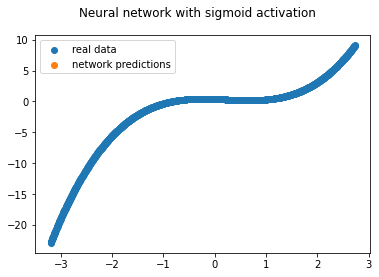

MSE: nan


In [3]:
nn = NeuralNetwork(1, 1, activation_function="linear", seed=324, verbose=False)

nn.add_layer(10)
nn.add_layer(10)
nn.create_output_layer()
linear_errors = nn.train(data['regression']['cube']['X_train'], data['regression']['cube']['y_train'], epochs=5, batch_size=10, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(data['regression']['cube']['X_test'])

# Plot example
plt.scatter(data['regression']['cube']['X_test'].flatten(), data['regression']['cube']['y_test'].flatten(), label='real data')
plt.scatter(data['regression']['cube']['X_test'].flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with sigmoid activation')
plt.show()

print("MSE: " + str(np.mean((pred - data['regression']['cube']['y_test'])**2)))

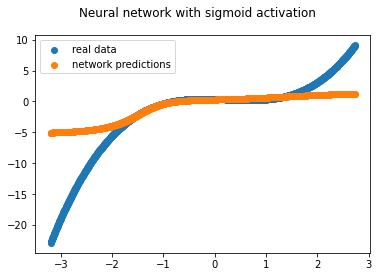

MSE: 21.793662964929226


In [4]:
nn = NeuralNetwork(1, 1, activation_function="sigma", seed=324, verbose=False)

nn.add_layer(10)
nn.add_layer(10)
nn.create_output_layer()
sigma_errors = nn.train(data['regression']['cube']['X_train'], data['regression']['cube']['y_train'], epochs=5, batch_size=10, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(data['regression']['cube']['X_test'])

# Plot example
plt.scatter(data['regression']['cube']['X_test'].flatten(), data['regression']['cube']['y_test'].flatten(), label='real data')
plt.scatter(data['regression']['cube']['X_test'].flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with sigmoid activation')
plt.show()

print("MSE: " + str(np.mean((pred - data['regression']['cube']['y_test'])**2)))

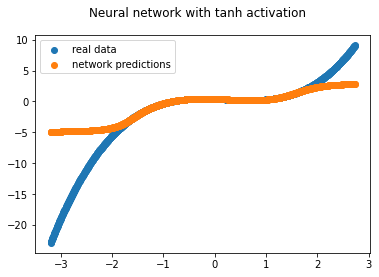

MSE: 20.337679779321604


In [5]:
nn = NeuralNetwork(1, 1, activation_function="tanh", seed=324, verbose=False)

nn.add_layer(10)
nn.add_layer(10)
nn.create_output_layer()
tanh_errors = nn.train(data['regression']['cube']['X_train'], data['regression']['cube']['y_train'], epochs=5, batch_size=10, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(data['regression']['cube']['X_test'])

# Plot example
plt.scatter(data['regression']['cube']['X_test'].flatten(), data['regression']['cube']['y_test'].flatten(), label='real data')
plt.scatter(data['regression']['cube']['X_test'].flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with tanh activation')
plt.show()

print("MSE: " + str(np.mean((pred - data['regression']['cube']['y_test'])**2)))

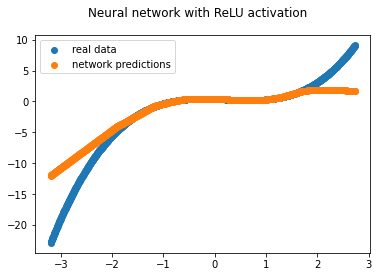

MSE: 8.556133991724348


In [6]:
nn = NeuralNetwork(1, 1, activation_function="relu", seed=324, verbose=False)

nn.add_layer(10)
nn.add_layer(10)
nn.create_output_layer()
relu_errors = nn.train(data['regression']['cube']['X_train'], data['regression']['cube']['y_train'], epochs=5, batch_size=10, lr=.005, method='basic', method_param=0.2)
pred = nn.predict(data['regression']['cube']['X_test'])

# Plot example
plt.scatter(data['regression']['cube']['X_test'].flatten(), data['regression']['cube']['y_test'].flatten(), label='real data')
plt.scatter(data['regression']['cube']['X_test'].flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with ReLU activation')
plt.show()

print("MSE: " + str(np.mean((pred - data['regression']['cube']['y_test'])**2)))

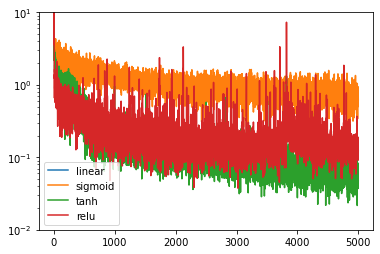

In [7]:
plt.plot(linear_errors, label='linear')
plt.plot(sigma_errors, label='sigmoid')
plt.plot(tanh_errors, label='tanh')
plt.plot(relu_errors, label='relu')
plt.legend()
plt.yscale("log")
plt.ylim(top=10, bottom=0.01)
plt.show()

The data provided was quite difficult for every activation function to process. Predictably, the linear activation function did not even finished the training properly, because weights exploded. The sigmoid is the worst of the most used trinity. In this test tanh was the best in converging on the training data, however, the ReLU got the best MSE on the testing dataset. One would say that it was a pure luck, but on the other hand the ReLU is widely known for its ability to generalize.

# Architecture

The networks ability to fit to training data is highly dependent on the number of networks in the hidden layers. In this experiment we trained several networks using identical parameters, increasing only the number of hidden neurons. As the results show, the error decreased as the number of neurons grew. It is however important to note, that tighter fit to data is often not desirable, as it leads to poor generalization of the model.

In [8]:
def get_error(activation, i):
    nn = NeuralNetwork(1, 1, activation_function=activation, verbose=False, seed=324)
    nn.add_layer(i)
    nn.create_output_layer()
    nn.errors = nn.train(data['regression']['cube']['X_train'], data['regression']['cube']['y_train'], epochs=5, batch_size=10, lr=.005, method='basic', method_param=0.2)
    pred = nn.predict(data['regression']['cube']['X_train'])
    return np.mean(np.power(pred-data['regression']['cube']['y_train'], 2))
n = 10
sigma_mse = np.empty(n)
tanh_mse = np.empty(n)
relu_mse = np.empty(n)
for i in range(1, n+1):
    sigma_mse[i-1] = get_error('sigma', i)
    tanh_mse[i-1] = get_error('tanh', i)
    relu_mse[i-1] = get_error('relu', i)

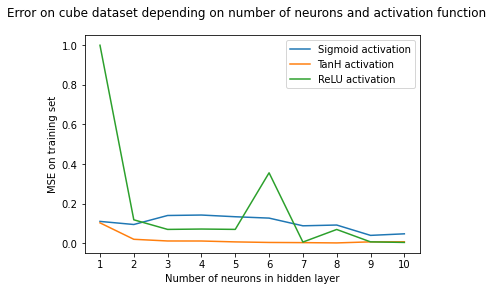

In [9]:
plt.plot(range(1, n+1), sigma_mse, label='Sigmoid activation')
plt.plot(range(1, n+1), tanh_mse, label='TanH activation')
plt.plot(range(1, n+1), relu_mse, label='ReLU activation')
plt.xlabel('Number of neurons in hidden layer')
plt.ylabel('MSE on training set')
plt.legend()
plt.xticks(list(range(1, n+1)))
plt.suptitle('Error on cube dataset depending on number of neurons and activation function')
plt.show()

As we can see the ReLU and tanh were quite responsive to adding neurons to the layer. The sigmoid performed quite worse, but it generally performs worse than two other methods. This test signs that broadening the nerual networks should enhance their performance, but we should bear in mind that making nets wider make the training time larger.

In [10]:
def get_error_depth(activation, i):
    nn = NeuralNetwork(1, 1, activation_function=activation, verbose=False, seed=324)
    for j in range(i):  
        nn.add_layer(5)
    nn.create_output_layer()
    nn.errors = nn.train(data['regression']['cube']['X_train'], data['regression']['cube']['y_train'], epochs=5, batch_size=10, lr=.005, method='basic', method_param=0.2)
    pred = nn.predict(data['regression']['cube']['X_train'])
    return np.mean(np.power(pred-data['regression']['cube']['y_train'], 2))
n = 5
sigma_mse = np.empty(n)
tanh_mse = np.empty(n)
relu_mse = np.empty(n)
for i in range(1, n+1):
    sigma_mse[i-1] = get_error_depth('sigma', i)
    tanh_mse[i-1] = get_error_depth('tanh', i)
    relu_mse[i-1] = get_error_depth('relu', i)

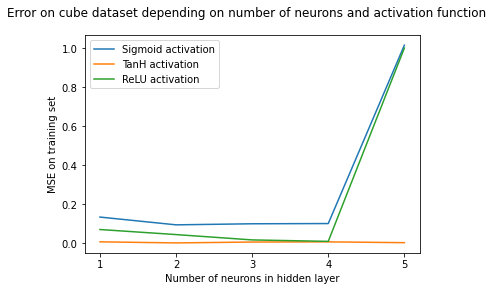

In [11]:
plt.plot(range(1, n+1), sigma_mse, label='Sigmoid activation')
plt.plot(range(1, n+1), tanh_mse, label='TanH activation')
plt.plot(range(1, n+1), relu_mse, label='ReLU activation')
plt.xlabel('Number of neurons in hidden layer')
plt.ylabel('MSE on training set')
plt.legend()
plt.xticks(list(range(1, n+1)))
plt.suptitle('Error on cube dataset depending on number of neurons and activation function')
plt.show()

In the case of adding layers to the net it is not as straightforward as in previous test. Adding layers makes the training a bit harder and the backpropagation less effective, so to compensate this we should tweak learning parameters to fit the training process to the architecture. However, in this test we wanted to see how the net would perform when changing only the number of hidden networks. The ReLU reacted poorly to the higher number of layers. On the other hand, tanh worked pretty well on all tested number of layer. Maybe it is a sign that we should use tanh in deeper network? Or maybe not...?

# Loss functions

Firstly, we will see how regression loss functions perform in our net. The most common used loss function is MSE and, to be honest, it is hard to find any regression loss function that would be used more than rarely. To compare MSE with any other loss function we implemented MAE for this task.

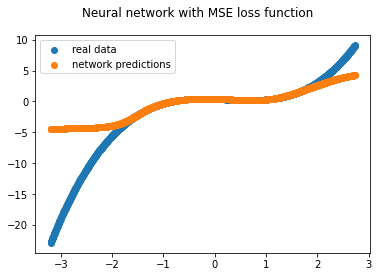

MSE: 21.230835348554265


In [12]:
nn = NeuralNetwork(1, 1, activation_function="tanh", seed=324, verbose=False, loss_function='mse')

# Multiple layers
nn.add_layer(10)
nn.add_layer(10)

nn.create_output_layer()
nn.errors = nn.train(data['regression']['cube']['X_train'], data['regression']['cube']['y_train'], epochs=10, batch_size=99, lr=.001, method='rmsprop', method_param=0.2)
pred = nn.predict(data['regression']['cube']['X_test'])

# Plot example


plt.scatter(data['regression']['cube']['X_test'].flatten(), data['regression']['cube']['y_test'].flatten(), label='real data')
plt.scatter(data['regression']['cube']['X_test'].flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with MSE loss function')
plt.show()

print("MSE: " + str(np.mean((pred - data['regression']['cube']['y_test'])**2)))

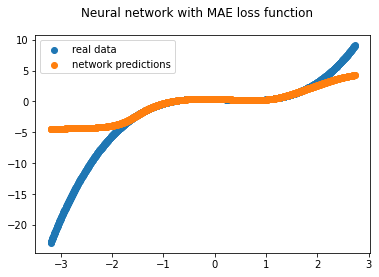

MSE: 21.230835348554265


In [13]:
nn = NeuralNetwork(1, 1, activation_function="tanh", seed=324, verbose=False, loss_function='mae')

# Multiple layers
nn.add_layer(10)
nn.add_layer(10)

nn.create_output_layer()
nn.errors = nn.train(data['regression']['cube']['X_train'], data['regression']['cube']['y_train'], epochs=10, batch_size=99, lr=.001, method='rmsprop', method_param=0.2)
pred = nn.predict(data['regression']['cube']['X_test'])

# Plot example


plt.scatter(data['regression']['cube']['X_test'].flatten(), data['regression']['cube']['y_test'].flatten(), label='real data')
plt.scatter(data['regression']['cube']['X_test'].flatten(), pred.flatten(), label='network predictions')
plt.legend()
plt.suptitle('Neural network with MAE loss function')
plt.show()

print("MSE: " + str(np.mean((pred - data['regression']['cube']['y_test'])**2)))

The MSE and the MAE are very similar so it is no surprise that they gave very similar results. The MSE is used more often, but looking at this test we can say that the MAE is not worse. Maybe there is another reason to use the MSE instead of MAE that we did not find in this test. After all, we recommend using MSE.

In the classification possible loss functions are a bit more interesting, because there comes a cross entropy. Every machine learning/data science guy knows what the cross entropy is and how interesting it is. Some students would ask why use the cross entropy if we can just use the MSE? It is a great question. Let's try to find answer in the following tests.

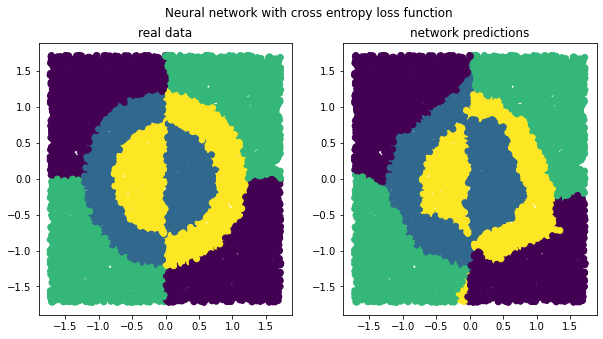

Acc: 0.9036


In [23]:
nn = NeuralNetwork(2, 4, activation_function="relu", loss_function='crossentropy', seed=324, verbose=False)

# Multiple layers
nn.add_layer(20)
nn.add_layer(20)
nn.add_layer(20)

nn.create_output_layer("softmax")
nn.errors = nn.train(data['classification']['circles']['X_train'], data['classification']['circles']['y_train'], epochs=10, batch_size=10, lr=.01, method='rmsprop', method_param=0.2)
pred = nn.predict(data['classification']['circles']['X_test'])

# Plot example

fig, axis = plt.subplots(1, 2, figsize=(10,5))

axis[0].scatter(data['classification']['circles']['X_test'][:,0], data['classification']['circles']['X_test'][:,1], c = np.argmax(data['classification']['circles']['y_test'], axis=1).flatten())
axis[0].set_title('real data')
axis[1].scatter(data['classification']['circles']['X_test'][:,0], data['classification']['circles']['X_test'][:,1], c = np.argmax(pred, axis=1).flatten())
axis[1].set_title('network predictions')
fig.suptitle('Neural network with cross entropy loss function')
plt.show()

print("Acc: " + str(np.mean((np.argmax(data['classification']['circles']['y_test'], axis=1).flatten() == np.argmax(pred, axis=1).flatten()))))

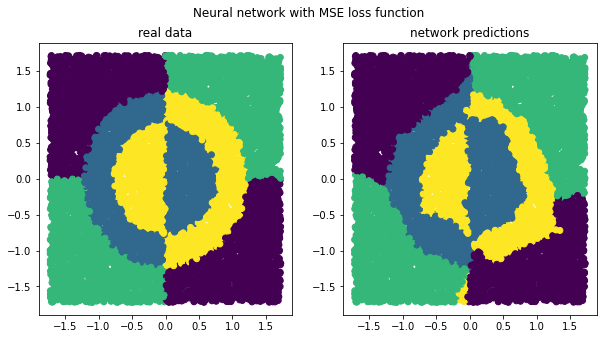

Acc: 0.9036


In [24]:
nn = NeuralNetwork(2, 4, activation_function="relu", loss_function='mse', seed=324, verbose=False)

# Multiple layers
nn.add_layer(20)
nn.add_layer(20)
nn.add_layer(20)

nn.create_output_layer()
nn.errors = nn.train(data['classification']['circles']['X_train'], data['classification']['circles']['y_train'], epochs=10, batch_size=10, lr=.01, method='rmsprop', method_param=0.2)
pred = nn.predict(data['classification']['circles']['X_test'])

# Plot example

fig, axis = plt.subplots(1, 2, figsize=(10,5))

axis[0].scatter(data['classification']['circles']['X_test'][:,0], data['classification']['circles']['X_test'][:,1], c = np.argmax(data['classification']['circles']['y_test'], axis=1).flatten())
axis[0].set_title('real data')
axis[1].scatter(data['classification']['circles']['X_test'][:,0], data['classification']['circles']['X_test'][:,1], c = np.argmax(pred, axis=1).flatten())
axis[1].set_title('network predictions')
fig.suptitle('Neural network with MSE loss function')
plt.show()

print("Acc: " + str(np.mean((np.argmax(data['classification']['circles']['y_test'], axis=1).flatten() == np.argmax(pred, axis=1).flatten()))))

In this test the cross entropy had the same accuracy as the MSE. So why is the cross entropy so widely used? Firstly, Its accuracy was quite similar to the MSE accuracy. The magic happens when you look at the graphs. The MSE had quite a big trouble with generalizing. We can see that there are a few spots with a completely different colour or kind of "bites" into another colour. There the training and testing data was quite similar, so the generalization was very hard see through accuracy. When you look at the cross entropy graph it is a bit smoother that the MSE graph.

# Bias

In this experiment we present the importance of using bias. Famously, bias was introduced to allow a network to solve the xor problem.
We created two nearly identical networks with two hidden layers with 10 neurons each, one using bias and one not. Then, we trained them on the xor dataset. Results show, that the network using bias was able to fit perfectly to the training data, while the other failed miserably.

In [16]:

nn = NeuralNetwork(2, 2, activation_function="tanh", loss_function='crossentropy', seed=324, verbose=False,  bias_exists=False)
nn.add_layer(10)
nn.add_layer(10)
nn.create_output_layer("softmax")
nn.errors = nn.train(data['classification']['XOR']['X_train'], data['classification']['XOR']['y_train'], epochs=2, batch_size=10, lr=.02, method='rmsprop', method_param=0.2)
pred_no_bias = nn.predict(data['classification']['XOR']['X_train'])

nn = NeuralNetwork(2, 2, activation_function="tanh", loss_function='crossentropy', seed=324, verbose=False,  bias_exists=True)
nn.add_layer(10)
nn.add_layer(10)
nn.create_output_layer("softmax")
nn.errors = nn.train(data['classification']['XOR']['X_train'], data['classification']['XOR']['y_train'], epochs=2, batch_size=10, lr=.02, method='rmsprop', method_param=0.2)
pred_bias = nn.predict(data['classification']['XOR']['X_train'])

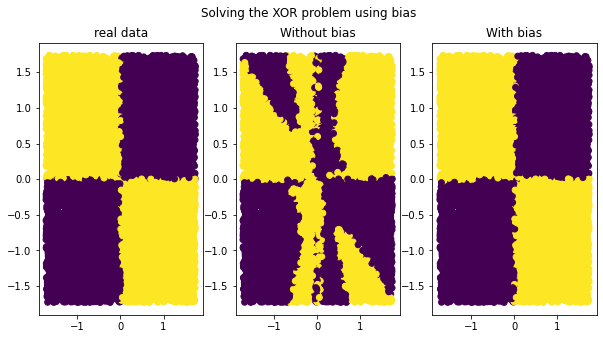

In [17]:

fig, axis = plt.subplots(1, 3, figsize=(10,5))

axis[0].scatter(data['classification']['XOR']['X_train'][:,0], data['classification']['XOR']['X_train'][:,1], c = np.argmax(data['classification']['XOR']['y_train'], axis=1).flatten())
axis[0].set_title('real data')
axis[1].scatter(data['classification']['XOR']['X_train'][:,0], data['classification']['XOR']['X_train'][:,1], c = np.argmax(pred_no_bias, axis=1).flatten())
axis[1].set_title('Without bias')
axis[2].scatter(data['classification']['XOR']['X_train'][:,0], data['classification']['XOR']['X_train'][:,1], c = np.argmax(pred_bias, axis=1).flatten())
axis[2].set_title('With bias')
fig.suptitle('Solving the XOR problem using bias')
plt.show()

# Training data size

Increasing the size of training data in general should lead to a better model. Larger datasets usually allow for higher accuracy and help prevent overfitting. In this experiment we created several networks using identical parameters, but taking a different size sample of the training dataset. Results show that on average increasing the number of observations lead to increase in accuracy on the test set.

In [ ]:
def get_error_size(activation, X_train, y_train):
    nn = NeuralNetwork(2, 3, activation_function=activation, verbose=False, seed=500)
    nn.add_layer(50)
    nn.add_layer(50)
    nn.create_output_layer()
    nn.errors = nn.train(X_train, y_train, epochs=3, batch_size=5, lr=.02, method='rmsprop', method_param=0.2)
    pred = nn.predict(data['classification']['three_gauss']['X_test'])
    return np.mean(np.power(pred-data['classification']['three_gauss']['y_test'], 2))
sizes = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
n = len(sizes)
relu_mse = np.zeros(n)
for i, size in enumerate(sizes):
    sample = np.random.choice(range(10000), size)
    X_train = data['classification']['three_gauss']['X_train'][sample,]
    y_train = data['classification']['three_gauss']['y_train'][sample,]
    relu_mse[i] = get_error_size('relu', X_train, y_train)

In [ ]:
plt.plot(sizes, relu_mse, label='ReLU activation')
plt.xlabel('Training dataset size')
plt.ylabel('MSE on test set')
plt.xticks(sizes)
plt.title('Error on three_gauss depending on training dataset size')
plt.show()

# Conclusion

This tests showed that constructing neural networks requires some basic knowledge about what some specific parameters can do and how they model the learning process of the network. As shown above any minor change in parameters can drasticly change the prediction quality of the neural network and the experience in constructing different architectures of neural networks can be very beneficial for someone who want to become the deep learning practitioner.